In [5]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings

# Suppress all RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
def generate_data(n_samples, n_features, c, tau_0):

    #generate the covariance matrix
    I = np.eye(n_features)
    ones = np.ones(n_features)
    C_x = (1-c)*I + c*np.outer(ones, ones)

    #make tau a column vector of tau_0 of lengeth p
    tau = [tau_0]*n_features

    # We need to construct the covariance matrix that they described in their theoretical frameowrk
    # This should be a matrix with C (covariance matrxi between Xj's) in the top left, tau^T (vector of cov(Xj,Y)) in the bottom left and tau in top right, and Var(Y) (1 for std. noraml) in the bottom right

    C = np.block([[C_x, np.array(tau).reshape(-1, 1)], [np.array(tau).reshape(1, -1), 1]])

    #generate noise
    eps = np.random.normal(0, 1)

    #generate X and Y from multivariate normal with mean 0 and the previously described covariance matrix
    mean = np.zeros(n_features+1)
    M = np.random.multivariate_normal(mean, C, n_samples)

    #extract X and Y, respectively
    X = M[:, :-1]
    Y = M[:,-1] + eps

    return X, Y


#Theoretical MDA* result from Gregorutti (2016)
def mda_star(tau_0, c, p):

    theoretical_mda = 2 * (tau_0 / (1 - c + p * c)) ** 2
    return theoretical_mda

#Function to run simulation
def simulation(model, n_samples, p, c, tau_0):

    #get data
    X,Y = generate_data(n_samples, p, c, tau_0)

    # fit off the shelf rf model
    model.fit(X, Y)

    # get empirical MDA values using scikit-learn permutation importance function (n_repeats specifies how many times average over to shuffle each feature and measure change in output)
    perm_importance = permutation_importance(model, X, Y, n_repeats=20, random_state=42)
    importance = perm_importance.importances_mean

    #compute the theoretical mda
    theoretical_mda_val = mda_star(tau_0, c, p)

    # store the results and corresponding p and c values
    sklearn_mda[(p, c)] = np.mean(importance)
    theoretical_mda[(p, c)] = theoretical_mda_val

    return sklearn_mda, theoretical_mda

#plotting function that takes results stored in two dictionaries
def plot_mda_results(sklearn_mdas, theoretical_mdas):
  # initialize
  fig, axes = plt.subplots(2, 1, figsize=(10, 10))

  # plot sklearn_mdas
  for p in p_values:
      # extract the c values and corresponding MDA values for each p
      c_vals = [c for c in c_values]
      mda_vals = [sklearn_mdas[(p, c)] for c in c_vals]

      axes[0].plot(c_vals, mda_vals, label=f"p = {p}")

  axes[0].set_title("Empirical MDA vs c values")
  axes[0].set_xlabel("c value")
  axes[0].set_ylabel("MDA (Sklearn)")
  axes[0].legend(title='Num. features, p')

  # plot theoretical_mdas
  for p in p_values:
      # extract the c values and corresponding theoretical MDA values for each p
      c_vals = [c for c in c_values]
      mda_vals = [theoretical_mdas[(p, c)] for c in c_vals]

      axes[1].plot(c_vals, mda_vals, label=f"p = {p}")

  axes[1].set_title("Theoretical MDA vs c values")
  axes[1].set_xlabel("c value (correlation coef. between Xj's)")
  axes[1].set_ylabel("MDA (Theoretical)")
  axes[1].legend(title='Num. features, p')

  plt.tight_layout()
  plt.show()


Now we want to run simulations to compare the emperical MDA results with the theoretical derived from the result in Gregorutti et. al.

We compare the emperical results to the theoretical values established in Gregorutti et. al. in two settings.

**Setting 1**: Fixed tau_0=0.9 for all p and c values (as they did in the paper).

**Setting 2** Using the largest tau_0 for each p and c. i.e. following the boundary on the region of invertibility between tau_0 and c for each p, (minus a small value for numerical reasons to stay beneath the curve)derived from solving the eigenvalue equations.


In [7]:
# set parameters that are constant across settings

model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', n_jobs=-1)
p_values = [2,3,4,5]
c_values = [0.01, 0.05, .1, .2, .25, .3, .35, .4, .45, .5, .6, .7, .8, .9]
n_samples = 5000

## Setting 1: fixed, invalid tau_0

In [8]:
#initialize dictionaries to store results
sklearn_mda = {}
theoretical_mda = {}

for p in p_values:
    for c in c_values:
        tau_0 = 0.9
        #generate the covariance matrix
        C_x = (1-c)*np.eye(p) + c*np.ones((p,p))
        tau = np.array([tau_0] * p).reshape(-1, 1)
        C = np.block([[C_x, tau], [tau.T, 1]])

        sklearn_mdas, theoretical_mdas, = simulation(model, n_samples, p, c, tau_0)

# here we get warnings for covariance matrix not positive semi-definite, but we suppress them

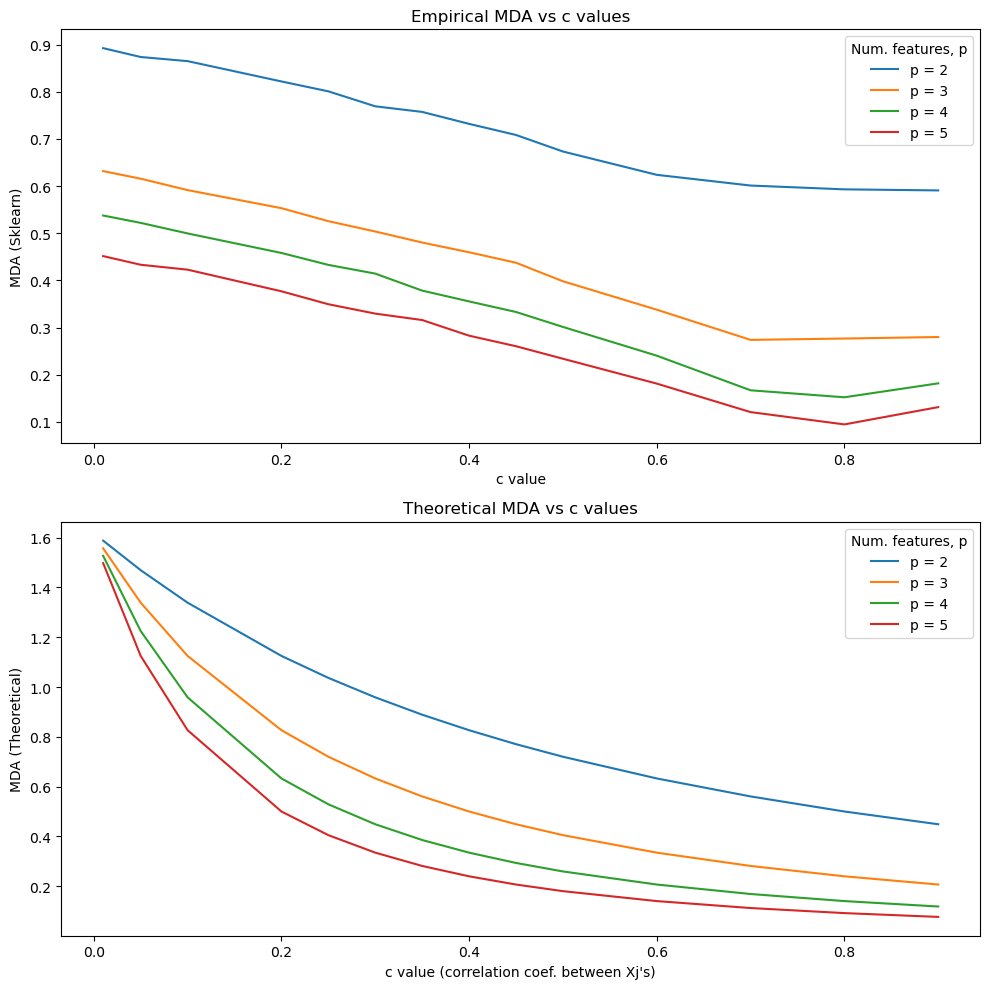

In [9]:
plot_mda_results(sklearn_mdas=sklearn_mda, theoretical_mdas=theoretical_mdas)

## Setting 2: Maximum valid tau_0 for each c, and p


In [10]:
#initialize dictionaries to store results
sklearn_mda = {}
theoretical_mda = {}

#define the functions to get the maximum tau_0 for a given c and p
def get_tau_0(c,p):
  num_safety_margin = 0.02
  if p == 2:
    return np.sqrt(1/2 * c +1/2) - num_safety_margin
  elif p == 3:
    return np.sqrt(2/3 * c + 1/3) - num_safety_margin
  elif p == 4:
    return np.sqrt(3/4 * c + 1/4) - num_safety_margin
  else:
    return np.sqrt(4/5 * c + 1/5) - num_safety_margin

for p in p_values:
    for c in c_values:
        tau_0 = get_tau_0(c,p)
        sklearn_mdas, theoretical_mdas, = simulation(model, n_samples, p, c, tau_0)


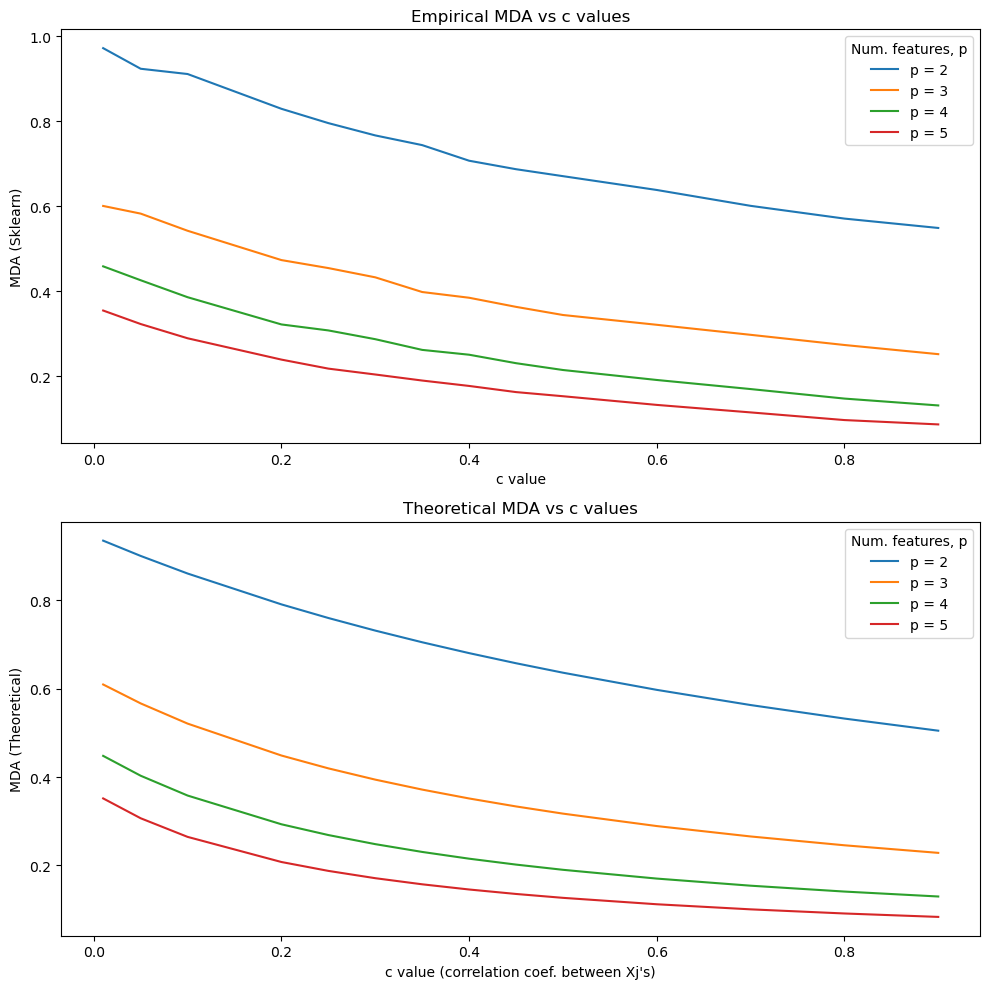

In [11]:
plot_mda_results(sklearn_mda, theoretical_mda)

We can see clearly here that when we use a fixed $\tau_0$, the emperical results do not align with the theoretical because, as we've said, this is an invalid combination of parameters.

Additionally, we can see that when we use the largest valid $\tau_0$, (we move along the boundary formed between $\tau_0$ and $c$ for each $c$ and $p$, our emperical results align well with the theoretical expectation.


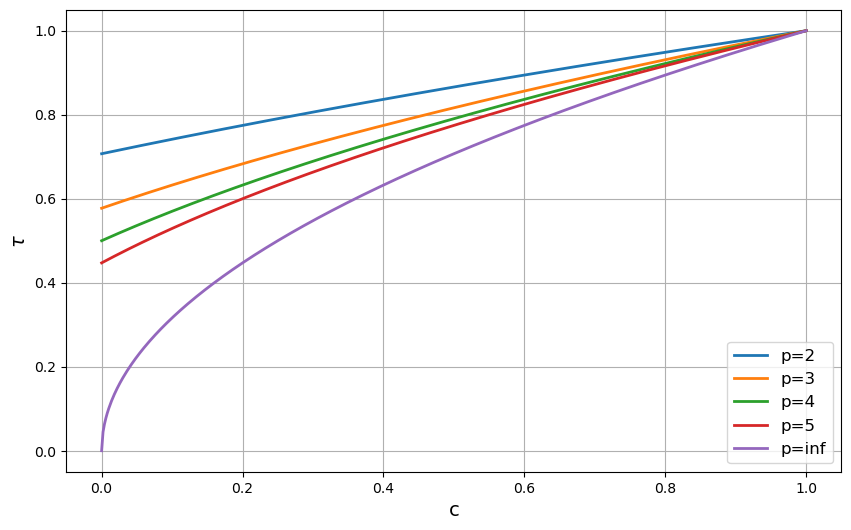

In [12]:
c = np.linspace(0, 1, 500)

# Calculate tau for different values of p
tau_p2 = np.sqrt(1/2 * c + 1/2)
tau_p3 = np.sqrt(2/3 * c + 1/3)
tau_p4 = np.sqrt(3/4 * c + 1/4)
tau_p5 = np.sqrt(4/5 * c + 1/5)
tau_pinf = np.sqrt(c)

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(c, tau_p2, label='p=2', linewidth=2)
plt.plot(c, tau_p3, label='p=3', linewidth=2)
plt.plot(c, tau_p4, label='p=4', linewidth=2)
plt.plot(c, tau_p5, label='p=5', linewidth=2)
plt.plot(c, tau_pinf, label='p=inf', linewidth=2)

# Add labels, legend, and grid
plt.xlabel('c', fontsize=14)
plt.ylabel(r'$\tau$', fontsize=14)
#plt.title('Plots of '+$\tau_0$+' for different values of $p$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()
